In [61]:
# Import the required libraries and modules

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch.nn.utils.prune as prune
from torch.nn.utils import weight_norm
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from captum.attr import LayerGradCam, visualization as viz
import numpy as np
import cv2

In [62]:
# Define the image transformations and load the MNIST dataset

# Image transformations for input data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define the architecture of the LeNet-5 model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.tanh(self.conv1(x)))
        x = self.pool(torch.tanh(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = torch.tanh(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

model = Net()

# Define the optimizer, criterion, and move the model to the CPU device
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cpu")
model.to(device)

# Train the model for a certain number of epochs:

epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
# Iterate over training data and perform forward and backward pass
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
# Prints average loss for each epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{epochs}, loss: {epoch_loss:.4f}")

# Evaluate the accuracy of the model on the test data   
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('\nAccuracy of the model : %d %%' % (100 * correct / total))

# # Check if the model is pruned
# is_pruned = prune.is_pruned(model)
# print("\nIs Pruned:", is_pruned)


Epoch 1/10, loss: 1.5454

Epoch 2/10, loss: 1.4901

Epoch 3/10, loss: 1.4832

Epoch 4/10, loss: 1.4798

Epoch 5/10, loss: 1.4774

Epoch 6/10, loss: 1.4755

Epoch 7/10, loss: 1.4744

Epoch 8/10, loss: 1.4737

Epoch 9/10, loss: 1.4737

Epoch 10/10, loss: 1.4724

Accuracy of the model : 98 %


Predicted Label: 5

Image:


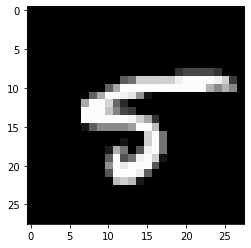

Image with GradCAM:


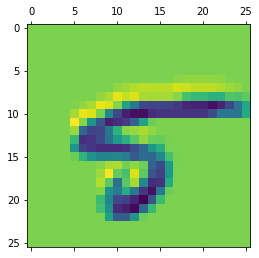

Combined Image:


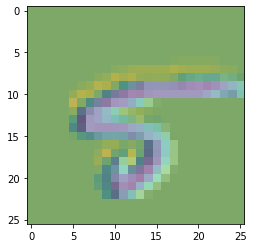

In [63]:
# Set the model to evaluation mode and choose a random image from the test dataset to display
model.eval()

with torch.no_grad():
    test_index = random.randint(0, len(test_dataset)-1)
    test_image, test_label = test_dataset[test_index]
    test_output = model(test_image.unsqueeze(0))
    _, predicted = torch.max(test_output.data, 1)
    print('Predicted Label:', predicted.item())
    print('\nImage:')
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.show()

# Apply GradCAM visualization to the chosen image
layers = list(model.modules())
image, label = test_image.unsqueeze(0), torch.tensor([predicted.item()])
algorithm = LayerGradCam(model, layer=layers[1])
feature_imp_img = algorithm.attribute(image, target=label)
# print(feature_imp_img.shape)
_, _, h, w = feature_imp_img.shape

# Display the GradCAM heat map
orig_image = np.transpose(test_image.numpy(), (1,2,0))
print('Image with GradCAM:')
plt.matshow(feature_imp_img.detach().numpy().reshape(h,w,1), interpolation ='none')
plt.show()   

print('Combined Image:')
# Load and display the first image
image1 = test_image.squeeze()
plt.imshow(image1, alpha=0.5, cmap='gray')
plt.axis('on')

# Load and display the second image with transparency
image2 = feature_imp_img.detach().numpy().reshape(h, w, 1)
plt.imshow(image2, alpha=0.5, interpolation='none')

# Show the combined image
plt.show()

In [64]:
# Specify the layers to prune
layers_to_prune = [model.conv1, model.conv2, model.fc1, model.fc2]

# Prune each layer individually
for layer in layers_to_prune:
    prune.ln_structured(module=layer, name='weight', amount=0.3, n=1, dim=1) # 0=row & 1=column
    
# Reinitialize the optimizer and criterion, and set the model to training mode    
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
criterion = torch.nn.CrossEntropyLoss()

model.train()

# Fine-tune the pruned model for a certain number of epochs
epochs = 10  
for epoch in range(epochs):
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Evaluate the accuracy of the pruned and fine-tuned model on the test data    
model.eval()

correct = 0
total = 0

model.eval()
with torch.no_grad():
    test_image = test_image.unsqueeze(0)
    output = model(test_image)
    _, predicted = torch.max(output, 1)

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
# for layer in layers_to_prune:
#     mask = getattr(layer, 'weight_mask', None)
#     if mask is not None:
#         sparsity = 1.0 - mask.float().mean()
#         sparsity_percentage = sparsity.item() * 100
#         print(f"Sparsity of {layer.__class__.__name__}: {sparsity_percentage:.2f}")

accuracy = 100 * correct / total
print(f"\nAccuracy of the pruned model: {accuracy:.2f}%")

# Check if the model is pruned after the fine-tuning
is_pruned = prune.is_pruned(model)
print("\nIs Pruned:", is_pruned)


Epoch 1/10, Loss: 1.5176

Epoch 2/10, Loss: 1.4871

Epoch 3/10, Loss: 1.4802

Epoch 4/10, Loss: 1.4773

Epoch 5/10, Loss: 1.4756

Epoch 6/10, Loss: 1.4745

Epoch 7/10, Loss: 1.4737

Epoch 8/10, Loss: 1.4730

Epoch 9/10, Loss: 1.4724

Epoch 10/10, Loss: 1.4719

Accuracy of the pruned model: 98.55%

Is Pruned: True


Predicted Label: 5

Pruned Image:


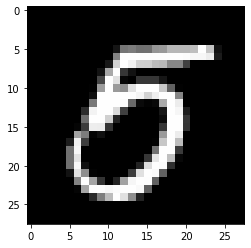

Pruned Image with GradCAM:


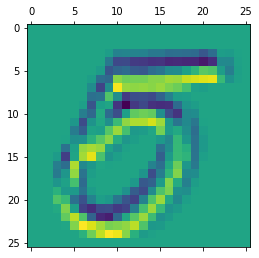

Combined Image:


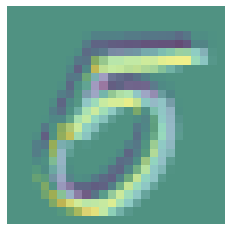

In [65]:
# Display the original image after pruning and apply GradCAM visualization to it
with torch.no_grad():
    test_index = random.randint(0, len(test_dataset)-1)
    test_image, test_label = test_dataset[test_index]
    test_output = model(test_image.unsqueeze(0))
    _, predicted = torch.max(test_output.data, 1)
    print('Predicted Label:', predicted.item())
    print('\nPruned Image:')
    plt.imshow(test_image.squeeze(), cmap='gray')
    plt.show()

# Apply GradCAM visualization to the same image
layers = list(model.modules())
image, label = test_image.unsqueeze(0), torch.tensor([predicted.item()])
algorithm = LayerGradCam(model, layer=layers[1])
feature_imp_img = algorithm.attribute(image, target=label)
_, _, h, w = feature_imp_img.shape

# Display the GradCAM heat map
orig_image = np.transpose(test_image.numpy(), (1, 2, 0))
print('Pruned Image with GradCAM:')
plt.matshow(feature_imp_img.detach().numpy().reshape(h, w, 1), interpolation='none')
plt.show()


print('Combined Image:')
# Load and display the first image
image1 = test_image.squeeze()
plt.imshow(image1, alpha=0.5, cmap='gray')
plt.axis('off')

# Load and display the second image with transparency
image2 = feature_imp_img.detach().numpy().reshape(h, w, 1)
plt.imshow(image2, alpha=0.5, interpolation='none')

# Show the combined image
plt.show()